In [1]:
import os
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 134443 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.17-0ubuntu2~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.17-0ubuntu2~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.17-0ubuntu2~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redir

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import os
os.chdir("drive/Deep learning in python") 

In [6]:
!ls

 6_2_rnn.ipynb					  aclImdb
 6_3_advanced_used_rnn.ipynb			  aclImdb.zip
'6-Deep learning for text  and sequences.ipynb'   jena_climate_2009_2016.csv


In [0]:
'''
读取文件，并且对文件进行处理
'''
f = open('jena_climate_2009_2016.csv')
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [8]:
header

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

In [9]:
len(lines)

420551

In [10]:
len(header)

15

In [0]:
'''
6-29解析数据
'''
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

In [12]:
float_data

array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
         2.0000e+00,  2.1520e+02],
       [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
         2.1600e+00,  2.2580e+02],
       [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
         1.9600e+00,  1.8490e+02]])

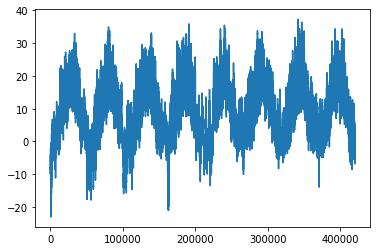

In [13]:
'''
6-30绘制温度时间序列
'''
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

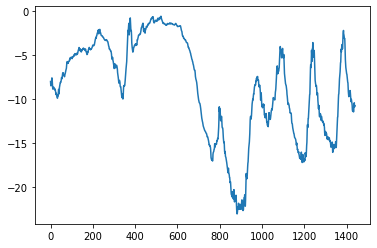

In [0]:
'''
6-31绘制前10天的温度时间序列
'''
plt.plot(range(1440), temp[:1440])

In [0]:
'''
6-32数据标准化
'''
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [0]:
'''
6-33生成时间序列样本及其目标的生成器
参数:
data:浮点数数据组成的原始数组，已经标准化
lookback:输入数据应该包括过去多少个时间步
delay:目标应该在未来多少个时间步之后
min_index和max_index:data数组中的索引，用于界定需要抽取哪些时间步。这有助于保存一部分数据用于验证，另一部分用于测试
shuffle:是打乱样本，还是按照顺序抽取样本
batch_size:每个批量的样本数
step:数据采样的周期（单位：时间步）。我们将其设为6，为的是每小时抽取一个数据点
'''

def generator(data, lookback, delay, min_index, max_index,
        shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)
    
    samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets


In [0]:
'''
6-34准备训练生成器，验证生成器和测试生成器
'''
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, shuffle=True, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, shuffle=True, step=step, batch_size=batch_size)


In [0]:
#为了查看验证集，需要从val_gen中抽取多少次
val_steps = (300000 - 200001 - lookback) // batch_size

#为了查看整个测试集，需要从test_gen中抽取多少次
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [18]:
val_steps

769

In [19]:
test_steps

930

In [20]:
'''
6-35计算符合常识的基准方法的MAE
'''
def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))

evaluate_naive_method()

0.2904219738350742


In [0]:
'''
6-36将MAE转换成摄氏温度差
'''
celsius_mae = 0.29 * std[1]

In [22]:
celsius_mae

2.5672247338393395

In [0]:
'''
6-37训练并评估一个密集连接模型
'''
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 11s 22ms/step - loss: 1.0164 - val_loss: 0.3881
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3343 - val_loss: 0.3045
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2756 - val_loss: 0.3050
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2594 - val_loss: 0.3103
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2507 - val_loss: 0.3162
Epoch 6/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2435 - val_loss: 0.3082
Epoch 7/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2371 - val_loss: 0.3198
Epoch 8/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2322 - val_loss: 0.3145
Epoch 9/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2251 - val_loss: 0.3373
Epoch 10/20
500/500 [==============================] - 12s 23ms/step - loss: 0.222

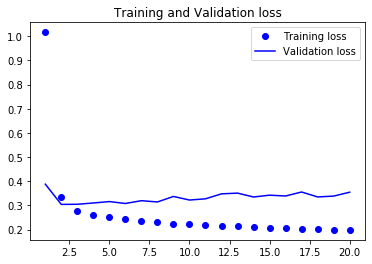

In [0]:
'''
6-38绘制结果
'''
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [0]:
'''
6-39训练并评估一个基于GRU的模型
'''
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
500/500 [==============================] - 151s 301ms/step - loss: 0.3023 - val_loss: 0.2745
Epoch 2/20
500/500 [==============================] - 149s 298ms/step - loss: 0.2854 - val_loss: 0.2651
Epoch 3/20
500/500 [==============================] - 150s 300ms/step - loss: 0.2758 - val_loss: 0.2660
Epoch 4/20
500/500 [==============================] - 159s 318ms/step - loss: 0.2706 - val_loss: 0.2671
Epoch 5/20
500/500 [==============================] - 155s 311ms/step - loss: 0.2659 - val_loss: 0.2657
Epoch 6/20
500/500 [==============================] - 157s 315ms/step - loss: 0.2605 - val_loss: 0.2710
Epoch 7/20
500/500 [==============================] - 154s 307ms/step - loss: 0.2550 - val_loss: 0.2650
Epoch 8/20
500/500 [==============================] - 155s 309ms/step - loss: 0.2501 - val_loss: 0.2702
Epoch 9/20
500/500 [==============================] - 156s 313ms/step - lo

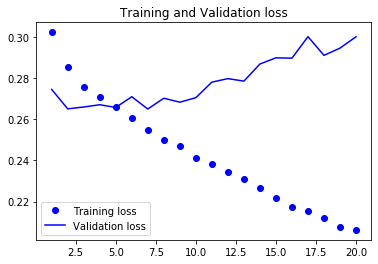

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [0]:
'''
6-40训练并评估一个使用dropout正则化的基于GRU的模型
'''
model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/40
500/500 [==============================] - 170s 340ms/step - loss: 0.3379 - val_loss: 0.2787
Epoch 2/40
500/500 [==============================] - 169s 338ms/step - loss: 0.3137 - val_loss: 0.2751
Epoch 3/40
500/500 [==============================] - 169s 339ms/step - loss: 0.3092 - val_loss: 0.2704
Epoch 4/40
500/500 [==============================] - 171s 343ms/step - loss: 0.3020 - val_loss: 0.2703
Epoch 5/40
500/500 [==============================] - 175s 350ms/step - loss: 0.3001 - val_loss: 0.2742
Epoch 6/40
500/500 [==============================] - 174s 347ms/step - loss: 0.2994 - val_loss: 0.2671
Epoch 7/40
500/500 [==============================] - 171s 341ms/step - loss: 0.2957 - val_loss: 0.2722
Epoch 8/40
500/500 [==============================] - 170s 339ms/step - loss: 0.2961 - val_loss: 0.2749
Epoch 9/40
500/500 [==============================] 

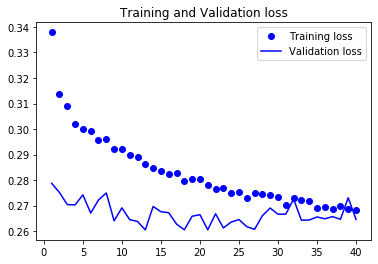

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [23]:
'''
6-41训练并且评估一个使用dropout正则化的堆叠GRU模型
'''
model = Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/40





500/500 [==============================] - 346s 691ms/step - loss: 0.3371 - val_loss: 0.2770
Epoch 2/40
500/500 [==============================] - 350s 701ms/step - loss: 0.3132 - val_loss: 0.2767
Epoch 3/40
500/500 [==============================] - 349s 698ms/step - loss: 0.3070 - val_loss: 0.2717
Epoch 4/40
500/500 [==============================] - 350s 700ms/step - loss: 0.3023 - val_loss: 0.2718
Epoch 5/40
500/500 [==============================] - 348s 696ms/step - loss: 0.2985 - val_loss: 0.2702
Epoch 6/40
500/500 [==============================] - 351s 702ms/step - loss: 0.2953 - val_loss: 0.2700
Epoch 7/40
500/500 [==============================] - 348s 696ms/step - loss: 0.2903 - val_loss: 0.2750
Epoch 8/40
500/500 [==============================

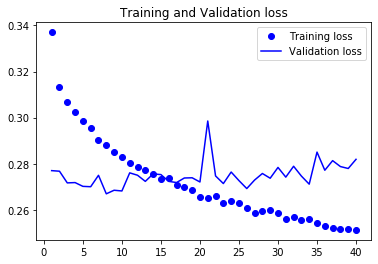

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()